# KINGFormer Work Overview

**Author**: Bhavana Jonnalagadda

Presentation of main findings and work performed, in an approximate sequential timeline.

## Setup

In [1]:
## Import meta setup

# In order to force reload any changes done to the models package files
%load_ext autoreload
%autoreload 2

# Allow import from our custom lib python files
import sys
import os

module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
import os
from collections import defaultdict

from lib.params import * # device, use_cuda, Checkpoint, various saving strs
from lib.datasets import KingMatrixDataset, RotatedMatrixDataset
from lib.models import BaseTransformer
from lib.saveload import *


import pandas as pd
import numpy as np
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import (zero_one_loss, rand_score, adjusted_rand_score, 
                            completeness_score, mutual_info_score, 
                            adjusted_mutual_info_score, normalized_mutual_info_score)
# Viz
from ipywidgets import widgets, Layout
from IPython import display 
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
# pio.renderers.default = "notebook+plotly_mimetype+png"
# For some reason, the correct setting to get the plots to show up in Quarto HTML?
pio.renderers.default = "plotly_mimetype+notebook+png"

ModuleNotFoundError: No module named 'lib'

### Helper Functions

In [3]:
pd.options.display.max_columns = 8

def disp_multiple_row(items):
    """Display multiple Jupyter outputs in a row instead of on tope of each other
    inspo: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side"""
    w_s = []
    for item in items:
        widget = widgets.Output()
        widget.append_display_data(item)
        w_s.append(widget)

    # add some CSS styles to distribute free space
    box_layout = Layout(display='flex',
                        flex_flow='row',
                        justify_content='space-around',
                        width='auto'
                       )
    # create Horisontal Box container
    hbox = widgets.HBox(w_s, layout=box_layout)
    
    # render hbox
    return hbox

def disp_title(text, level=3):
    return display.display(display.HTML(f"<h{level}>{text}</h{level}>"))

def get_reduced_by(X, labels, keepinds=20):
    rot_inds = list(range(0, 2503, keepinds))
    rot_labels = labels[rot_inds]
    rot_X = X[rot_inds][:, rot_inds]

    return rot_X, rot_labels, rot_inds

## Input Data

The input is a KING matrix of kinship relationships between 2503 individuals from the 1000 Genome project; it is an upper triangular matrix (all the entries at or below the main diagonal are zero). Herefore the "filled input matrix" refers to where the matrix is filled with the values flipped across the diagonal (as they are equivalent to be filled with those relationship values).

In [4]:
df_X = pd.read_csv(os.path.normpath("../Data/king_matrix_withnames.csv"), index_col=0)
X = df_X.to_numpy()
X_filled = RotatedMatrixDataset(os.path.normpath("../Data/king_matrix.csv"), pad=0, filled=True)

disp_title("Original Input Matrix (With Individual Labels)")
display.display(df_X)
disp_title("Filled Input Matrix")
X_filled.X

,HG00097,HG00099,HG00100,HG00101,...,NA21141,NA21142,NA21143,NA21144
ID1,,,,,,,,,
HG00096,-0.0091,-0.0023,-0.0143,0.0077,...,-0.0494,-0.0278,-0.0340,-0.0348
HG00097,0.0000,-0.0004,0.0173,0.0383,...,-0.0144,-0.0066,0.0074,-0.0152
HG00099,0.0000,0.0000,0.0147,0.0277,...,-0.0303,-0.0347,-0.0333,-0.0283
HG00100,0.0000,0.0000,0.0000,0.0399,...,-0.0205,-0.0278,-0.0235,-0.0265
HG00101,0.0000,0.0000,0.0000,0.0000,...,-0.0067,-0.0162,-0.0113,-0.0150
...,...,...,...,...,...,...,...,...,...
NA21135,0.0000,0.0000,0.0000,0.0000,...,0.0036,0.0099,-0.0065,-0.0013
NA21137,0.0000,0.0000,0.0000,0.0000,...,-0.0230,-0.0220,-0.0058,-0.0230
NA21141,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0187,0.0126,0.0150


array([[-0.0091, -0.0023, -0.0143, ..., -0.0278, -0.034 , -0.0348],
       [ 0.    , -0.0004,  0.0173, ..., -0.0066,  0.0074, -0.0152],
       [-0.0004,  0.    ,  0.0147, ..., -0.0347, -0.0333, -0.0283],
       ...,
       [-0.0144, -0.0303, -0.0205, ...,  0.0187,  0.0126,  0.015 ],
       [-0.0066, -0.0347, -0.0278, ...,  0.    ,  0.0161, -0.0096],
       [ 0.0074, -0.0333, -0.0235, ...,  0.0161,  0.    ,  0.0181]])

### Input Labels

All input has a given population and superpopulation label, the text descriptions of which given below.

In [5]:
# Labels as ints
y = pd.read_csv("../Output/Heritage_UMAP/labels_file_series.csv", index_col=0)["0"]
# Label int to popcode
king_popcodes = pd.read_csv("../Output/Heritage_UMAP/variable_to_integer_conversion_tribe_string_labels.csv", index_col=0)\
                    .set_index("0").to_dict()["1"]

sample_to_popcode = pd.read_csv("../Data/igsr_samples.tsv", sep="\t")[["Sample name", "Population code", "Superpopulation code", "Superpopulation name"]].dropna()
pop_to_superpop = sample_to_popcode.set_index("Population code").to_dict()["Superpopulation code"]
superpop_to_name = sample_to_popcode.set_index("Superpopulation code").to_dict()["Superpopulation name"]

# Labels as descriptive names
y_names = pd.read_csv("../Output/Heritage_UMAP/umap_embeddings.csv").iloc[:, -1]
pop_to_name = {king_popcodes[v]: y_names[i].replace("\n", " - ") for i, v in enumerate(y)}
# Labels as popcodes
y_codes = y.replace(king_popcodes)
y_superpop = y_codes.replace(pop_to_superpop)
y = y.to_numpy().flatten()

disp_multiple_row([pop_to_name, superpop_to_name])

## Dimensionality reduction on input

Input population clusters are shown by various dimensionality reduction methods: PCA, t-SNE, and UMAP. UMAP is chosen as most informative and is used later for dimensionality reduction. The points are colored by their true label, 

In [6]:
pca_X = PCA(n_components=2).fit_transform(X)
tsne_X = TSNE(n_components=2, random_state=42, 
            perplexity=30, learning_rate=200, early_exaggeration=12, n_iter=1000, init='pca'
             ).fit_transform(X)
umap_2d_X = UMAP(n_components=2).fit_transform(X)
umap_3d_X = UMAP(n_components=3).fit_transform(X)

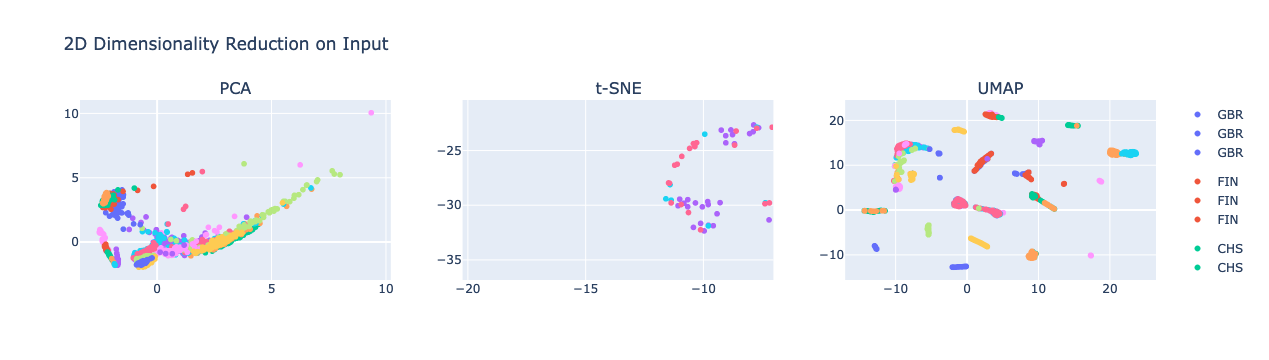

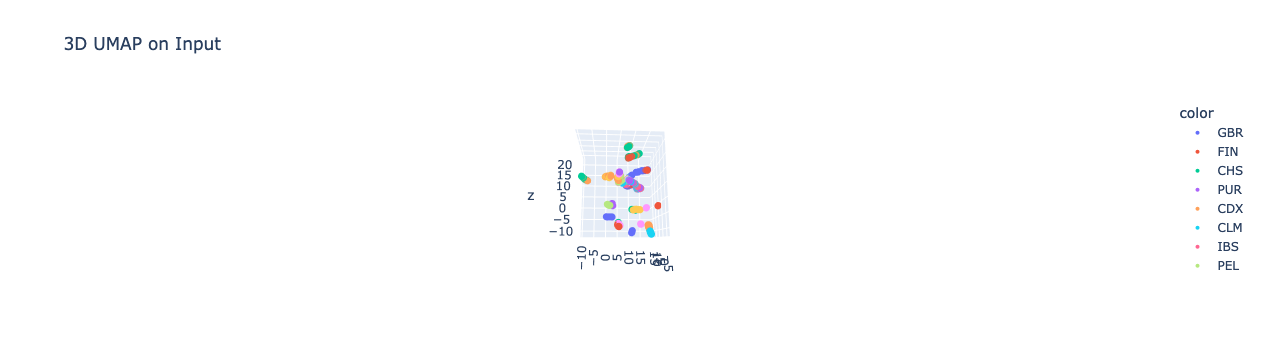

In [7]:
fig = make_subplots(rows=1, cols=3, subplot_titles=["PCA", "t-SNE", "UMAP"])

for i, p in enumerate([pca_X, tsne_X, umap_2d_X]):
    for d in px.scatter(x=p[:, 0], y=p[:, 1], color=y_codes).data:
        fig.add_trace(d, row=1, col=i+1)
    # fig.add_traces(px.scatter(x=p[:, 0], y=p[:, 1], color=y_codes).data)
fig.update_layout(title_text="2D Dimensionality Reduction on Input")
fig.show()

fig = px.scatter_3d(x=umap_3d_X[:, 0], y=umap_3d_X[:, 1], z=umap_3d_X[:, 2], color=y_codes, title="3D UMAP on Input")
fig.update_traces(marker=dict(size=4))
fig.update_layout(height=500)
fig.show()

### Subset of data: UMAP

Dimensionality reduction on a subset of the data -- every 10th observation, every 20th observation, etc -- shows similar patterns and division by population. 

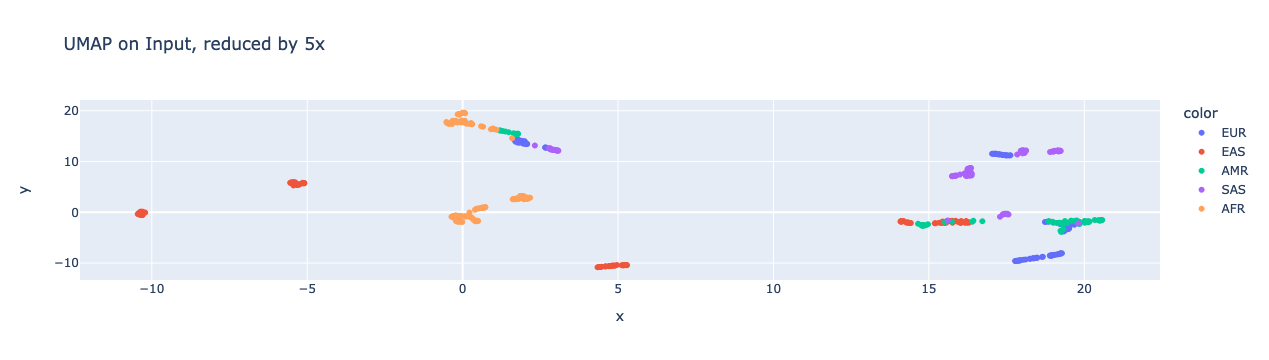

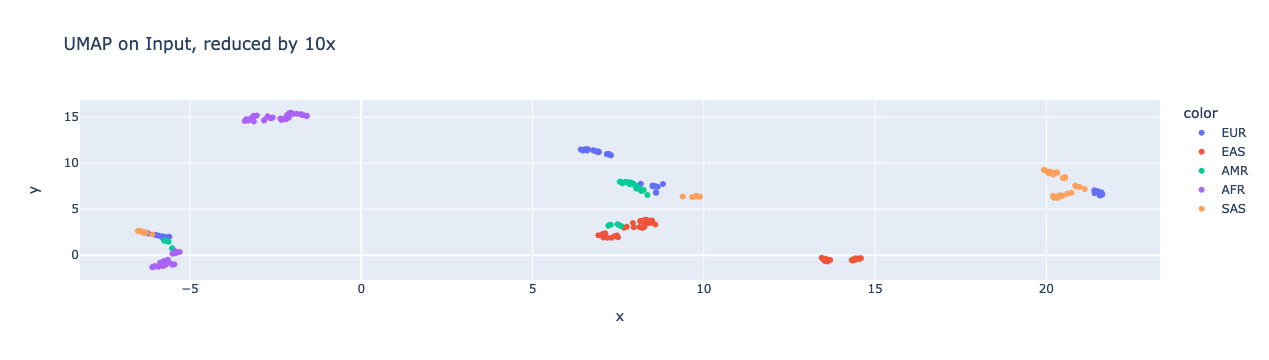

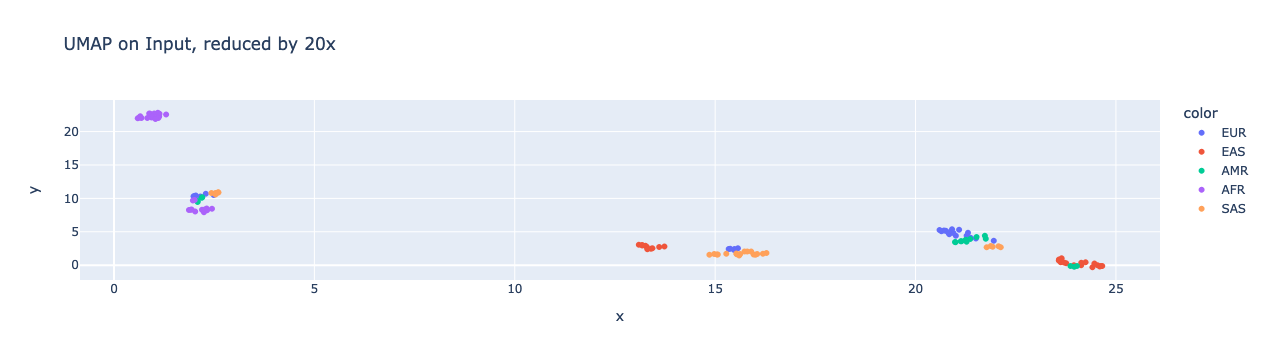

In [11]:
def get_reduced_by(X, labels, keepinds=20):
    rot_inds = list(range(0, 2503, keepinds))
    rot_labels = labels[rot_inds]
    rot_X = X[rot_inds][:, rot_inds]

    return rot_X, rot_labels, rot_inds

for i in [5, 10, 20]:
    red_X, red_labels, red_inds = get_reduced_by(X, y_superpop, i)
    red_umap_input = UMAP(n_components=2).fit_transform(red_X)
    red_umap_input_3d = UMAP(n_components=3).fit_transform(red_X)

    fig = px.scatter(x=red_umap_input[:, 0], y=red_umap_input[:, 1], color=red_labels.to_list(), 
                     title=f"UMAP on Input, reduced by {i}x")
    fig.show()

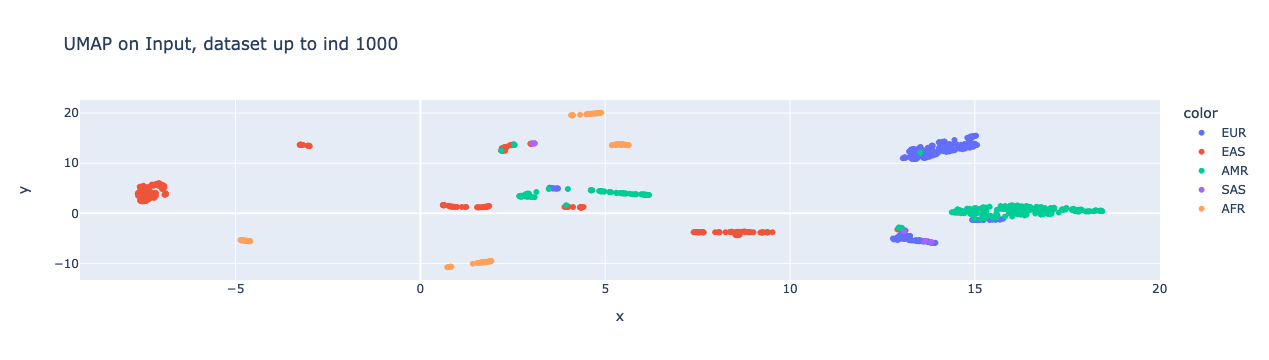

In [11]:
indmax = 1000
red_X, red_labels, red_inds = X[:indmax, :][:, :indmax], y_superpop[:indmax], range(indmax)
red_umap_input = UMAP(n_components=2).fit_transform(red_X)
fig = px.scatter(x=red_umap_input[:, 0], y=red_umap_input[:, 1], color=red_labels.to_list(), 
                 title=f"UMAP on Input, dataset up to ind {indmax}")
fig.show()